In [1]:
#BLOCK 1
#performing all required imports

import os
import re
import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter import filedialog as fd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
from tkinter import IntVar, Button
import itertools
import colorsys
import asyncio
from tornado import ioloop
from scipy.stats import linregress
from tkinter import filedialog

In [2]:
#BLOCK 2
def start_asyncio_loop():
    loop = asyncio.get_event_loop()
    ioloop.IOLoop.current().start()

def stop_asyncio_loop(loop):
    print("Stopping asyncio loop...")
    loop.stop()


In [3]:
#BLOCK 3
def generate_distinct_colors(num_colors):
    
#Generate a list of distinct colors by cycling through the hue in the HSL color space. The hue difference depends on the input variable num_colours. This ensures that every line plotted on the graphs has a different colour.
    
    colors = []
    for i in range(num_colors):
        hue = i / num_colors  # Cycle hue from 0 to 1
        color = colorsys.hls_to_rgb(hue, 0.6, 0.6)  # Keep saturation and lightness constant
        colors.append(color)
    return colors

def get_ncol(num_colors):

#Returns the number of columns to use in the legend based on the number of lines to be plotted.

    if num_colors <= 28:
        return 1
    elif 28 < num_colors <= 56:
        return 2
    elif 56 < num_colors <= 84:
        return 3
    elif 85 < num_colors <= 113:
        return 4
    elif 114 < num_colors <= 142: 
        return 5
    elif 143 < num_colors <= 171:
        return 6
    else:
        return 7

In [4]:
#BLOCK 4
# Load data function
def load_file():
    #user input to navigate to the csv they wish to analyse
    path = fd.askopenfilename()
    #define wavelengths as global variables so these can be accessed in plotting functions and used to label graphs
    global Abs_wavelength
    global Fl_wavelength
    if path:
        d1 = pd.read_csv(path, header=None, encoding="utf-8")

        # Find the row where the first column contains "Reading". This allows for different numbers of rows above the start of the dataset.
        reading_row = d1[d1.iloc[:, 0] == "Reading"].index[0]

        # Search for "Absorbance" or "Fluorescence" using regex (case-insensitive), to identify the data type. This will be used for labelling of graphs
        absorbance_row = None
        fluorescence_row = None

        for idx, value in enumerate(d1.iloc[:, 0]):
            if re.search(r'Absorbance', str(value), re.IGNORECASE):
                absorbance_row = idx
            elif re.search(r'Fluorescence', str(value), re.IGNORECASE):
                fluorescence_row = idx

        

        if absorbance_row is not None:
            # Extract wavelength value from the row containing "Wavelength". This is used to label the graph with the specific wavelength.
            Abs_raw = str(d1.iloc[absorbance_row + 1, 0]) 
            Abs_match = re.search(r'(\d+\s*nm)', Abs_raw)
            if Abs_match:
                Abs_wavelength = "Absorbance at " + Abs_match.group(1)
            else:
                Abs_wavelength = "Absorbance"

            

        elif fluorescence_row is not None:
            # Extract wavelengths from the "Fluorescence" row 
            Fluorescence_raw = str(d1.iloc[fluorescence_row + 1, 0])
            Fluorescence_match = re.search(r'Ex\s*(\d+)\s*nm.*Em\s*(\d+)\s*nm', Fluorescence_raw)
            if Fluorescence_match:
                Fl_wavelength = "RFU (" + f"{Fluorescence_match.group(1)}/{Fluorescence_match.group(2)}" + " nm)"
            else:
                Fl_wavelength = "RFU"

        
        else:
            print("No valid 'Absorbance' or 'Fluorescence' row found.")
            return

        
        data = pd.read_csv(path, skiprows=reading_row - 1, encoding="utf-8")
        num_columns = len(data.columns)
        data = pd.read_csv(path, skiprows=reading_row - 1, usecols=range(1, num_columns), encoding='utf-8')
        # Drop the last row as this has unneccessary data in it
        data = data[:-1]
        data_tr = data.transpose()
        # Access the first column of the modified DataFrame for time_pts
        time_pts = [float(i) for i in data.iloc[1:, 0]]  # This accesses all the rows in the first column        
        time_hours = [time / 60 for time in time_pts]

        # Extract the well names from row 12 (index 11), starting from column 3 (index 2)
        well_names_raw = data.iloc[0, 1:].values  # Extracting from the correct row and columns
        well_names_raw = [str(well_name) for well_name in well_names_raw]
        
        
        wells = []
        content = []
        for well_name in well_names_raw:
            match = re.search(r'\((.*?)\)', well_name)  # Regular expression to match text inside brackets
            if match:
                wells.append(match.group(1))  # Extract the part inside the brackets
                # Extract the part before the bracket, and remove the space
                content_name = well_name.split('(')[0].strip()  # Get part before the first bracket
                content.append(content_name)  # Add to content list
        heads = ["content", "well", "time", "time_h", "OD"]
        df = pd.DataFrame(columns=heads)
        
#content list is not currently used, but this is the list of sample names that the user has entered in settig up the platereader. potential to use this "content" list in future to give more plotting options.

    if wells is not None and content is not None:
        # Initialize od_list for each well
        od_list = []  # List to store OD values corresponding to each well
        dfs_to_concatenate = []  # List to collect all the DataFrames for concatenation

        for wl in range(len(wells)):  # Iterate over each well
            cont_list = []  # To store content for each well
            well_list = []  # To store well names for each well
            
            # Get the column index corresponding to the well
            well_column_index = wl + 1  # Since data starts from column 2 (index 1 in Python)

            # Collect OD values corresponding to the column for the current well
            od_values = list(data.iloc[1:, well_column_index])  # Get the OD values from the well column
            # Ensure od_values are numeric and handle any invalid values
            od_values = pd.to_numeric(od_values, errors='coerce')  # Convert to numeric, setting invalid entries as NaN
            od_values = od_values[od_values > 0]  # Filter out values that are <= 0 (log is undefined for non-positive values)
            # Now you can safely compute the log of the OD values
            ln_od_values = [np.log(a) for a in od_values]  # Calculate ln(OD) for each OD value

            
            cleaned_lists = [
                (t, th, od, ln_od)
                for t, th, od, ln_od in zip(time_pts, time_hours, od_values, ln_od_values)
                if pd.notna(t) and pd.notna(th) and pd.notna(od) and pd.notna(ln_od)
            ]


            # Unzip the filtered lists for time_pts, time_hours, od_values, and ln_od_values
            time_pts_cleaned, time_hours_cleaned, od_values_cleaned, ln_od_values_cleaned = zip(*cleaned_lists) if cleaned_lists else ([], [], [], [])

            # Now, create a DataFrame for the cleaned data
            # Note that the lengths of group should match
            # If they do not match, we'll need to truncate the longer list(s) to the length of the shorter list(s)
            
            min_len = min(len(time_pts_cleaned), len(time_hours_cleaned), len(od_values_cleaned), len(ln_od_values_cleaned))
            
            # Truncate the longer lists if necessary

            time_pts_cleaned = time_pts_cleaned[:min_len]
            time_hours_cleaned = time_hours_cleaned[:min_len]
            od_values_cleaned = od_values_cleaned[:min_len]
            ln_od_values_cleaned = ln_od_values_cleaned[:min_len]



            if len(time_pts_cleaned) != len(od_values_cleaned):
             print(f"Warning: Length mismatch between time_pts and OD values for well {wells[wl]}")



            for i in range(len(time_pts_cleaned)):
                cont_list.append(content[wl])  # Append the content (e.g., Un0001)
                well_list.append(wells[wl])    # Append the well name (e.g., H01)
                
            # Create DataFrame for this well
            to_add = pd.DataFrame({
                "content": cont_list,
                "well": well_list,
                "time": time_pts_cleaned,
                "time_h": time_hours_cleaned,
                "OD": od_values_cleaned,  # Use the OD values specific to the current well
                "lnOD": ln_od_values_cleaned  # Calculate ln(OD) for each OD value
            })
            
            # Add this DataFrame to the list of DataFrames
            dfs_to_concatenate.append(to_add)

        # Concatenate all dataframes to create the final dataframe
        df = pd.concat(dfs_to_concatenate, ignore_index=True)
        return df
    else:
        print("No file selected")
        return None


In [5]:
#BLOCK 5
# Plotting function
def plot_all_data(df, y_label, title):
    fig, ax = plt.subplots()
    #number of colours for line colour function is the number of datasets
    num_colors = len(df['well'].unique())
    colors = generate_distinct_colors(num_colors)
    # Create a color iterator
    color_cycle = itertools.cycle(colors)

    # Get the appropriate number of columns for the legend
    ncol = get_ncol(num_colors)

    # Iterate through each well
    for well in df['well'].unique():
        data_subset = df[df['well'] == well]
        
        # Get the next linestyle and color for each well
        color = next(color_cycle)

         
        ax.plot(data_subset['time_h'], data_subset['OD'], label=well, color=color)

    ax.set_ylabel(y_label)
    ax.set_xlabel('Time (min)')
    # Adjust the position of the legend to be outside the plot area (to the right)
    ax.legend(ncol=ncol, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
    ax.set_title(title + " across all wells")
    ax.set_aspect("auto")
    ax.autoscale(enable=True)
    ax.margins(x=0)
    plt.show()


In [6]:
#BLOCK 6
# Class for pop up window generation, including blank selection, plotting and linear regression.

class BlankSelectionApp:
    def __init__(self, root, df):

        self.root = root
        self.df = df
        self.selected_blanks = []
        self.selected_wells_groups = {}
        self.gradient_dict = {}
        self.vars = []
        self.cols = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
        self.blank_selection_window = None
        self.blank_subtracted = False
        self.plate_type = "96-well"  # Default plate type
        self.rows = 8
        self.columns = 12
        self.row_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
        self.df_gradient = pd.DataFrame(columns=['well', 'gradient', 'error', 'min_time', 'max_time'])


  #pop up window to ask user what plate size they are analysing  
    def ask_for_plate_type(self):
        # Create a new Toplevel window for plate selection
        plate_window = Toplevel(self.root)
        plate_window.title("Select Plate Type")
        
        # Question label
        question_label = Label(plate_window, text="What is your plate size?")
        question_label.grid(row=0, column=0, padx=10, pady=10)
        
        # Create a dropdown (OptionMenu) for plate size selection
        plate_options = ["24-well", "48-well", "96-well", "384-well"]
        plate_var = StringVar()
        plate_var.set(plate_options[0])  # Default value is the first option
        
        plate_dropdown = OptionMenu(plate_window, plate_var, *plate_options)
        plate_dropdown.grid(row=1, column=0, padx=10, pady=10)
        
        # Function to handle the confirmation button click
        def confirm_plate_type():
            self.plate_type = plate_var.get()  # Store the selected plate type
            if self.plate_type == "24-well":
                self.rows = 4
                self.columns = 6
            elif self.plate_type == "48-well":
                self.rows = 6
                self.columns = 8
            elif self.plate_type == "96-well":
                self.rows = 8
                self.columns = 12
            elif self.plate_type == "384-well":
                self.rows = 16
                self.columns = 24

            
            print(f"Selected Plate Type: {self.plate_type}")  
            plate_window.destroy()  # Close the plate selection window
            self.ask_for_blank_subtraction() #proceed to blank subtraction once the plate type has been confirmed
    
        # Confirmation button
        confirm_button = Button(plate_window, text="Confirm", command=confirm_plate_type)
        confirm_button.grid(row=2, column=0, padx=10, pady=10)
    
 #pop up window to ask user if they want to subtract blank value from all wells   
    def ask_for_blank_subtraction(self):
        blank_subtract_window = Toplevel(self.root)
        blank_subtract_window.title("Blank Wells Subtraction")
    
        response = Label(blank_subtract_window, text="Do you want to subtract blank wells?")
        response.grid(row=0, column=0, columnspan=2, pady=10)

         # Second question: "Do you want to subtract a custom blank value?"
        custom_blank_label = Label(blank_subtract_window, text="Alternatively enter a custom blank value")
        custom_blank_label.grid(row=2, column=0, columnspan=2, pady=10)   

        # Entry for custom blank value
        self.custom_blank_value = Entry(blank_subtract_window)
        self.custom_blank_value.grid(row=3, column=0, columnspan=2, pady=5)

    
        def yes_response():
            blank_subtract_window.destroy()
            self.blank_subtracted = True  # True when blank subtraction is performed
            self.custom_blank_subtracted = False  # No custom blank subtraction
            self.select_wells()
        
    
        def no_response():
            blank_subtract_window.destroy()
            self.blank_subtracted = False  # False if no blank subtraction
            self.custom_blank_subtracted = False  # No custom blank subtraction
            on_blanking_confirmation(self.df, is_blank_subtracted=False)
            self.ask_for_user_defined_wells()

        # Function to submit custom blank value
        def submit_custom_value():
            custom_blank = self.custom_blank_value.get()  # Get the custom blank value entered
            if custom_blank:
                blank_subtract_window.destroy()
                self.custom_blank_value = float(custom_blank)
                self.custom_blank_subtracted = True
                print(f"Custom blank value set to: {self.custom_blank_value}")
                #the function called below contains plotting hence the absorbance/fluorescence labels are given
                if Abs_wavelength is not None:
                    self.subtract_custom_value(Abs_wavelength, "Absorbance")
                elif Fl_wavelength is not None:
                    self.subtract_custom_value(Fl_wavelength, "Fluorescence")
                
            else:
                self.custom_blank_subtracted = False
                print("No custom blank value provided.")
    
        Button(blank_subtract_window, text="Yes", command=yes_response).grid(row=1, column=0, padx=10, pady=10)
        Button(blank_subtract_window, text="No", command=no_response).grid(row=1, column=1, padx=10, pady=10)

        # Button for submitting custom blank value
        submit_button = Button(blank_subtract_window, text="Submit custom value", command=submit_custom_value)
        submit_button.grid(row=4, column=0, columnspan=2, pady=10)

    def select_wells(self):
        master = self.root
        self.blank_selection_window = Toplevel(master)  # Store the reference to the blank selection window
        self.blank_selection_window.title("Select Blank Wells")
        
        # Call the reusable function here
        self.create_blank_well_selection_window(self.blank_selection_window)
        if self.rows == 16:
            Button(self.tab1, text="Apply Blank Subtraction", command=self.blank_wells_selected).grid(row=20, column=0, columnspan=self.columns, pady=10)
        else:
            Button(self.tab1, text="Apply Blank Subtraction", command=self.blank_wells_selected).grid(row=10, column=0, columnspan=self.columns, pady=10)



    def subtract_custom_value(self, y_label, title):
        if hasattr(self, 'custom_blank_value') and self.custom_blank_value is not None:
        # Ensure that the custom_blank_value exists
            print(f"Subtracting custom blank value: {self.custom_blank_value} from all datapoints.")
        

            for well in self.df["well"].unique():
                self.df.loc[self.df["well"] == well, "OD_blanked"] = self.df.loc[self.df["well"] == well, "OD"] - self.custom_blank_value


            
        # After subtraction, print first few rows to verify the data
            print(self.df.head())  
        
        # Update variable to indicate that the subtraction has been done
            self.custom_blank_subtracted = True
            print("Custom blank subtraction complete.")

            #plot the blank subtracted graph

            fig, ax = plt.subplots()
            num_colors = len(self.df['well'].unique())
            colors = generate_distinct_colors(num_colors)
            # Create a color iterator
            color_cycle = itertools.cycle(colors)
    
            # Get the appropriate number of columns for the legend
            ncol = get_ncol(num_colors)
            for well in self.df['well'].unique():
                #do not plot the blank wells
                if well not in self.selected_blanks:
                    data_subset = self.df[self.df['well'] == well]
                    color = next(color_cycle)
                    if not data_subset.empty and 'OD_blanked' in data_subset.columns:
                        ax.plot(data_subset['time_h'], data_subset['OD_blanked'], label=well, color=color)
                    else:
                        print(f"Warning: No valid data for well {well}. Skipping plot.")
        
            ax.set_ylabel(y_label)
            ax.set_xlabel('Time (min)')
            ax.legend(ncol=ncol, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
            ax.set_title(title + " across all wells (Blank Subtracted)")
            ax.set_aspect("auto")
            ax.autoscale(enable=True)
            ax.margins(x=0)
            plt.show()
    
            self.ask_for_user_defined_wells()
            #calling the next plotting function for the user to select wells to be plotted

        else:
            print("No custom blank value provided. Cannot perform subtraction.")





    
    def create_blank_well_selection_window(self, master_window):
        #Function to create the pop-up window layout for selecting blank wells.
        
        tabControl = ttk.Notebook(master_window)
        self.tab1 = ttk.Frame(tabControl)
        tabControl.add(self.tab1, text="Well Analysis")
        
        tabControl.grid(row=0, column=0, sticky="nsew")  # Grid layout for tabControl
        checkbox_font_size = 8 if self.rows == 16 else 10 #smaller font for large plates
        # Initialize the checkbox variables for each well
        self.vars = []
        for i in range(self.rows):  # Loop based on dynamic rows
            self.vars.append([])
            for j in range(self.columns):  # Loop based on dynamic columns
                self.vars[i].append(IntVar())
                name = f"{self.row_labels[i]}{str(j + 1).zfill(2)}"  # Added zfill here to ensure all wells labeled in same format
                
                checkbox = Checkbutton(self.tab1, text=name, variable=self.vars[i][j], font=("Arial", checkbox_font_size))
                checkbox.grid(row=i + 1, column=j + 1, sticky=W, padx=1, pady=1)  # Reduced padding for compact layout        
        # Add select all buttons for rows and columns
        self.create_select_all_buttons(self.tab1, self.vars)


    def create_select_all_buttons(self, tab_frame, checkbox_vars):
        #Function to create 'Select All' and 'Deselect All' buttons for rows and columns.

        class select_all_across:
            def __init__(self, row_no, vars, columns):
                self.row_no = row_no
                self.vars = vars
                self.columns = columns

            def set_values(self):
                
                for a in range(self.columns):
                    self.vars[self.row_no][a].set(1)

        for i in range(self.rows):
            inst_across = select_all_across(i, checkbox_vars, self.columns)
            if self.rows == 16:
                Button(tab_frame, text="all", command=inst_across.set_values).grid(row=i + 1, column=0, sticky=W, padx=2, pady=0.1)
            else:
                Button(tab_frame, text="all", command=inst_across.set_values).grid(row=i + 1, column=0, sticky=W, padx=2, pady=0.1)

        # Select all wells down a column
        class select_all_down:
            def __init__(self, col_no, vars, rows):
                self.col_no = col_no
                self.vars = vars  # Now we pass and store self.vars
                self.rows = rows
        
            def set_values(self):
                for a in range(self.rows):
                    self.vars[a][self.col_no].set(1)  # Access self.vars here
       
        # Inside create_select_all_buttons function
        for i in range(self.columns):
            inst_down = select_all_down(i, checkbox_vars, self.rows)  # Pass self.vars here
            Button(tab_frame, text="all", command=inst_down.set_values).grid(row=0, column=i + 1, sticky=W, padx=0.1, pady=0.1)


        # Add 'Select All' and 'Deselect All' buttons
        def select_all():
            for i in range(self.rows):
                for j in range(self.columns):
                    checkbox_vars[i][j].set(1)

        def deselect_all():
            for i in range(self.rows):
                for j in range(self.columns):
                    checkbox_vars[i][j].set(0)
        #different layout for the large 384-well plate to ensure all buttons visible. can replace this with a dynamic row number 
        if self.rows == 16:
            Button(tab_frame, text="Select All", command=select_all).grid(row=20, column=0, columnspan=2, sticky=W, pady=4)
            Button(tab_frame, text="Deselect All", command=deselect_all).grid(row=20, column=3, columnspan=self.columns, sticky=W, pady=4)
        else:
            Button(tab_frame, text="Select All", command=select_all).grid(row=11, column=0, columnspan=2, sticky=W, pady=4)
            Button(tab_frame, text="Deselect All", command=deselect_all).grid(row=12, column=0, columnspan=self.columns, sticky=W, pady=4)

    def blank_wells_selected(self):
        self.selected_blanks = [f"{self.cols[i]}{str(j + 1).zfill(2)}" for i in range(self.rows) for j in range(self.columns) if self.vars[i][j].get() == 1]  # Added zfill here
        if self.selected_blanks:
            if Abs_wavelength is not None:
                self.subtract_blank_averages(Abs_wavelength, "Absorbance")
            elif Fl_wavelength is not None:
                self.subtract_blank_averages(Fl_wavelength, "Fluorescence")





        
        else:
            print("No blank wells selected!")
        

        

    def subtract_blank_averages(self, y_label, title):
        #subtracting blanks from wells
        print(f"Selected blank wells: {self.selected_blanks}")

        if not self.selected_blanks:
            print("No blank wells selected! Skipping blank subtraction.")
            return

        blank_avg_values = {}
        for well in self.selected_blanks:
            blank_data = self.df[self.df["well"] == well]
            if not blank_data.empty:
                blank_avg = np.mean(blank_data["OD"])
                blank_avg_values[well] = blank_avg
            else:
                print(f"Warning: No data found for blank well {well}. Skipping this well.")

        for well in self.df["well"].unique():
            if well not in self.selected_blanks:
                blank_avg = np.mean([blank_avg_values[bw] for bw in self.selected_blanks if bw in blank_avg_values])
                self.df.loc[self.df["well"] == well, "OD_blanked"] = self.df.loc[self.df["well"] == well, "OD"] - blank_avg
                self.df.loc[self.df["well"] == well, "lnOD"] = np.log(np.maximum(self.df.loc[self.df["well"] == well, "OD_blanked"], 1e-10))

        print("Blank subtraction complete.")
        self.blank_selection_window.destroy()
        print(self.df[['well', 'OD', 'OD_blanked', 'time']].head())

        fig, ax = plt.subplots()
        num_colors = len(self.df['well'].unique())
        colors = generate_distinct_colors(num_colors)
        # Create a color iterator
        color_cycle = itertools.cycle(colors)

        # Get the appropriate number of columns for the legend
        ncol = get_ncol(num_colors)
        for well in self.df['well'].unique():
            if well not in self.selected_blanks:
                data_subset = self.df[self.df['well'] == well]
                color = next(color_cycle)
                if not data_subset.empty and 'OD_blanked' in data_subset.columns:
                    ax.plot(data_subset['time_h'], data_subset['OD_blanked'], label=well, color=color)
                else:
                    print(f"Warning: No valid data for well {well}. Skipping plot.")
    
        ax.set_ylabel(y_label)
        ax.set_xlabel('Time (min)')
        ax.legend(ncol=ncol, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
        ax.set_title(title + " across all wells (Blank Subtracted)")
        ax.set_aspect("auto")
        ax.autoscale(enable=True)
        ax.margins(x=0)
        plt.show()

        self.ask_for_user_defined_wells()


    def ask_for_user_defined_wells(self):
        # Create a new Toplevel window for user-defined wells (wells the user wants to plot)
        user_defined_window = Toplevel(self.root)
        user_defined_window.title("Select User-defined Wells for Plotting")
        tabControl = ttk.Notebook(user_defined_window)
        self.tab1 = ttk.Frame(tabControl)
        tabControl.add(self.tab1, text="Individual Well Analysis")
        #second tab for group analysis i.e. averages of multiple wells
        self.tab2 = ttk.Frame(tabControl)
        tabControl.add(self.tab2, text="Group Analysis")

        tabControl.grid(row=0, column=0, padx=10, pady=10)

        #Setup of tab1
        # Initialize the checkbox variables for each well (similar to blank wells)
        vars_user_defined = []
        for i in range(self.rows):
            vars_user_defined.append([])
            for j in range(self.columns):
                vars_user_defined[i].append(IntVar())
                name = f"{self.cols[i]}{str(j + 1).zfill(2)}"  # Added zfill here
                Checkbutton(self.tab1, text=name, variable=vars_user_defined[i][j]).grid(row=i + 1, column=j + 1, padx=0, pady=0, sticky=W)
    
        self.create_select_all_buttons(self.tab1, vars_user_defined)

        # Add a checkbox to select whether to use lnOD or OD
        well_log = BooleanVar()  # Define the BooleanVar for well_log
        well_log.set(0)  # Default to False (OD)
        Checkbutton(self.tab1, text="Plot lnOD instead of OD", variable=well_log).grid(row=22, column=0, columnspan=self.columns, sticky=W, pady=1)
        # Add the "Calculate Gradient" button to the user-defined window
        Button(self.tab1, text="Crop and Calculate Gradient", command=lambda: self.ask_for_time_range(vars_user_defined)).grid(row=23, column=8, columnspan=self.columns, pady=1)
        Button(self.tab1, text="Save Gradients", command=self.save_gradients).grid(row=24, column=8, columnspan=self.columns, pady=1)
        Button(self.tab1, text="End Script", command=self.on_end_button_pressed).grid(row=25, column=8, columnspan=self.columns, pady=1)
        # Plot the selected wells
        if Abs_wavelength is not None:
            Button(self.tab1, text="Plot", command=lambda: self.plot_selected_wells(vars_user_defined, Abs_wavelength)).grid(row=22, column=8, columnspan=self.columns, pady=1)
            
        elif Fl_wavelength is not None:
            Button(self.tab1, text="Plot", command=lambda: self.plot_selected_wells(vars_user_defined, Fl_wavelength)).grid(row=22, column=8, columnspan=self.columns, pady=1)
           


       

        #setup of tab2
        # Label for the question about the number of groups
        Label(self.tab2, text="How many groups of wells would you like to analyse?").grid(row=0, column=0, padx=10, pady=10)
        
        # Entry field for the user to enter the number of groups
        self.groups_entry = Entry(self.tab2)
        self.groups_entry.grid(row=1, column=0, padx=10, pady=10)
        
        # Button to confirm the number of groups
        Button(self.tab2, text="Confirm number of groups", command=self.confirm_groups).grid(row=2, column=0, padx=10, pady=10)
        
        # Instructional text explaining the grouping functionality
        Label(self.tab2, text="Wells can be grouped together and the averages of these wells will be plotted.").grid(row=3, column=0, padx=10, pady=10)
        Label(self.tab2, text="Select the number of groups of wells you would like to plot on the graph.").grid(row=4, column=0, padx=10, pady=10)
        Label(self.tab2, text="You will then have the option to select the wells for each of the groups you wish to plot.").grid(row=5, column=0, padx=10, pady=10)       

    def confirm_groups(self):
        # Retrieve the number of groups entered by the user
        num_groups = self.groups_entry.get()
        
        try:
            num_groups = int(num_groups)  # Convert to integer
            if num_groups > 0:
                print(f"Number of groups to analyze: {num_groups}")
                self.create_group_well_selection(num_groups=num_groups)
            
            else:
                print("Please enter a valid number greater than 0.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")


    def create_group_well_selection(self, num_groups):
        # Create a new Toplevel window for well selection
        group_selection_window = Toplevel(self.root)
        group_selection_window.title("Group Well Selection")
        
        # Create a Notebook (tabbed interface) for group selection
        tabControl = ttk.Notebook(group_selection_window)
        
        # Create the tabs dynamically based on the number of groups
        for group_num in range(1, num_groups + 1):
            tab = ttk.Frame(tabControl)
            tabControl.add(tab, text=f"Group {group_num}")
            
            # Initialize checkbox variables for well selection in this tab
            vars_group = []
            for i in range(self.rows):
                vars_group.append([])
                for j in range(self.columns):
                    vars_group[i].append(IntVar())
                    name = f"{self.cols[i]}{str(j + 1).zfill(2)}"
                    Checkbutton(tab, text=name, variable=vars_group[i][j]).grid(row=i + 1, column=j + 1, sticky=W)
            self.create_select_all_buttons(tab, vars_group)

            # Initialize group name input field with a default value
            group_name_input = Entry(tab)
            group_name_input.insert(0, f"Group {group_num}")  # Default value for the group name
            group_name_input.grid(row=self.rows + 1, column=0, columnspan=4, pady=5)
    
            # Store well selections and group name in the instance
            self.selected_wells_groups[group_num] = {
                'name': group_name_input,
                'wells': vars_group,
                'include_se_var': IntVar()  # Initialize the checkbox variable here
            }
    
            # Add a "Confirm well selection" button for each tab
            Button(tab, text="Confirm well selection", command=lambda group=group_num, vars=vars_group, group_name_input=group_name_input: self.confirm_well_selection(group, vars, group_name_input)).grid(row=self.rows + 3, column=0, columnspan=self.columns, pady=2)
    
           

            # For the final tab, add a "Plot" button
            if group_num == num_groups:
                
                Button(tab, text="Crop and Calculate Gradient", command=lambda: self.ask_for_time_range(vars_group, True)).grid(row=self.rows + 5, column=0, columnspan=self.columns, pady=1)
                if Abs_wavelength is not None:
                    Button(tab, text="Plot", command=lambda group=group_num, window=group_selection_window: self.plot_group_data(group, window, Abs_wavelength)).grid(row=self.rows + 4, column=0, columnspan=self.columns, pady=2)    
                elif Fl_wavelength is not None:
                    Button(tab, text="Plot", command=lambda group=group_num, window=group_selection_window: self.plot_group_data(group, window, Fl_wavelength)).grid(row=self.rows + 4, column=0, columnspan=self.columns, pady=2)
                                      
                Checkbutton(tab, text="Include standard error for all groups", variable=self.selected_wells_groups[num_groups]['include_se_var']).grid(row=self.rows + 2, column=0, columnspan=self.columns, pady=2)
        
        # Grid the tabs into the window
        tabControl.grid(row=0, column=0, padx=10, pady=10)


    
    def confirm_well_selection(self, group_num, vars_group, group_name_input):
        # Process well selection for this specific group
        selected_wells = []
        for i in range(self.rows):
            for j in range(self.columns):
                if vars_group[i][j].get() == 1:  # If the checkbox is selected
                    selected_wells.append(f"{self.cols[i]}{str(j + 1).zfill(2)}")
    
        # Update the selected wells, group name, and include_se checkbox state for the current group
        include_se_var = self.selected_wells_groups[group_num]['include_se_var']
        self.selected_wells_groups[group_num].update({
            'wells': selected_wells,
            'name': group_name_input.get(),  # Get the group name from the input field
            'include_se': include_se_var.get()  # Get the checkbox state (True or False)
        })
        
        # Print confirmation for debugging
        print(f"Group {group_num} selected wells: {selected_wells}, Group Name: {group_name_input.get()}, Include SE: {include_se_var.get()}")
    
    


    
    
    def plot_selected_wells(self, vars_user_defined, y_label, min_time=None, max_time=None):
        #plotting function for individual selected wells
        fig, ax = plt.subplots()
        cols = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
        df_mod_well = pd.DataFrame()

        for i in range(self.rows):
            for j in range(self.columns):
                if vars_user_defined[i][j].get() == 1:
                    well_name = f"{cols[i]}{str(j + 1).zfill(2)}"
                    df_mod_well = pd.concat([df_mod_well, self.df.query("well==@well_name")], ignore_index=True)

        num_colors = len(df_mod_well['well'].unique())
        colors = generate_distinct_colors(num_colors)
        # Create a color iterator
        color_cycle = itertools.cycle(colors)

        # Get the appropriate number of columns for the legend
        ncol = get_ncol(num_colors)

        # Filter data by the specified time range if min_time and max_time are provided
        if min_time is not None and max_time is not None:
            df_mod_well = df_mod_well[(df_mod_well['time_h'] >= min_time) & (df_mod_well['time_h'] <= max_time)]
        
        # Check whether blank subtraction was performed
        for well in df_mod_well['well'].unique():
            data_subset = df_mod_well[df_mod_well['well'] == well]
            color = next(color_cycle)
            if self.blank_subtracted or self.custom_blank_subtracted:  # Check if blank subtraction was performed
                ax.plot(data_subset['time_h'], data_subset['OD_blanked'], label=well, color=color)
                ax.set_title("Selected Wells (Blank Subtracted)")
            else:
                ax.plot(data_subset['time_h'], data_subset['OD'], label=well, color=color)
                ax.set_title("Selected Wells")

        ax.set_ylabel(y_label)
        ax.set_xlabel('Time (min)')
        ax.legend(ncol=ncol, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)  
        ax.set_aspect("auto")
        ax.autoscale(enable=True)
        ax.margins(x=0)
        plt.show()
       


    def ask_for_time_range(self, vars_user_defined, group_data=False):
        #pop up window to ask user for the time range they would like to crop the data to
        # Create a new Toplevel window for time range input
        time_range_window = Toplevel(self.root)
        time_range_window.title("Select Time Range for Gradient Calculation")

        # Minimum time input
        Label(time_range_window, text="Enter Minimum Time (min):").grid(row=0, column=0, padx=10, pady=5)
        min_time_entry = Entry(time_range_window)
        min_time_entry.grid(row=0, column=1, padx=10, pady=5)

        # Maximum time input
        Label(time_range_window, text="Enter Maximum Time (min):").grid(row=1, column=0, padx=10, pady=5)
        max_time_entry = Entry(time_range_window)
        max_time_entry.grid(row=1, column=1, padx=10, pady=5)

        # Button to confirm the time range
        Button(time_range_window, text="Confirm Time Range", 
               command=lambda: self.confirm_time_range(vars_user_defined, min_time_entry, max_time_entry, time_range_window, group_data)).grid(row=2, column=0, columnspan=2, pady=10)

    def confirm_time_range(self, vars_user_defined, min_time_entry, max_time_entry, time_range_window, group_data=False):
        # Get the values from the Entry widgets
        try:
            min_time = float(min_time_entry.get())  # Convert the user input to float
            max_time = float(max_time_entry.get())  # Convert the user input to float
        except ValueError:
            # If invalid input, show an error and return
            messagebox.showerror("Invalid input", "Please enter valid numbers for the time range.")
            return
    
        self.calculate_gradient(vars_user_defined, min_time, max_time, group_data)        

    
        # Close the time range window after confirming
        time_range_window.destroy()

    
    def calculate_gradient(self, vars_user_defined, min_time, max_time, group_data=False):
        if group_data==False:
            # Extract the selected wells
            selected_wells = []
            for i in range(self.rows):
                for j in range(self.columns):
                    if vars_user_defined[i][j].get() == 1:
                        selected_wells.append(f"{self.cols[i]}{str(j + 1).zfill(2)}")
        
            # Filter the dataframe to include only the selected wells
            df_mod_well = self.df[self.df['well'].isin(selected_wells)]
        
            # Filter the data by the time range
            df_mod_well = df_mod_well[(df_mod_well['time_h'] >= min_time) & (df_mod_well['time_h'] <= max_time)]
        
            # Calculate the gradient for each selected well
            gradient_rows = []  # List to store the rows for the gradients
            for well in df_mod_well['well'].unique():
                well_data = df_mod_well[df_mod_well['well'] == well]
                time_range_data = well_data[(well_data['time_h'] >= min_time) & (well_data['time_h'] <= max_time)]
        
                # Perform linear regression on the time range data
                slope, intercept, r_value, p_value, std_err = linregress(time_range_data['time_h'], time_range_data['OD'])
        
                # Store the gradient and other information in a dictionary
                self.gradient_dict[well] = {
                    'gradient': slope,
                    'error': std_err,
                    'min_time': min_time,
                    'max_time': max_time
                }
            

        
            # After calculating gradients, plot the selected wells and gradients
            if Abs_wavelength is not None:
                self.plot_selected_wells(vars_user_defined, Abs_wavelength, min_time=min_time, max_time=max_time)      
            elif Fl_wavelength is not None:
                self.plot_selected_wells(vars_user_defined, Fl_wavelength, min_time=min_time, max_time=max_time)

            
            
    
        else:
            group_num = len(self.selected_wells_groups) 
            if Abs_wavelength is not None:
                self.plot_group_data(group_num, None, Abs_wavelength, min_time=min_time, max_time=max_time)       
            elif Fl_wavelength is not None:
                self.plot_group_data(group_num, None, Fl_wavelength, min_time=min_time, max_time=max_time) 
                
    def save_gradients(self):
        # Ask the user to choose a file location to save the CSV
        file_path = filedialog.asksaveasfilename(defaultextension='.csv', filetypes=[("CSV Files", "*.csv")])
        
        if file_path:
            # Convert the gradient dictionary into a list of rows
            rows = []
            for key, value in self.gradient_dict.items():
                row = {'name': key}  # Add a 'name' column for well/group names
                row.update(value)  # Add the rest of the values for gradient, error, etc.
                rows.append(row)
            
            # Create a DataFrame from the rows
            df = pd.DataFrame(rows)
            
            # Save the DataFrame as a CSV file
            df.to_csv(file_path, index=False)
            print(f"Gradient data saved to {file_path}")
        else:
            print("File save cancelled")
    


    def plot_group_data(self, group_num, group_selection_window, y_label,  min_time=None, max_time=None):
        # Initialize the combined DataFrame for all selected groups
        df_combined = pd.DataFrame()
    
        # Loop through each group and get the selected wells
        for group in range(1, group_num + 1):
            selected_wells = self.selected_wells_groups.get(group, {}).get('wells', [])
            
            # Loop through each selected well and append the data to df_combined
            for well in selected_wells:
                data_subset = self.df[self.df['well'] == well]
                
                # Safely drop the first row by position if it exists
                if len(data_subset) > 0:
                    data_subset = data_subset.iloc[1:]  # This drops the first row by position
            
                # Append the data to the combined DataFrame
                df_combined = pd.concat([df_combined, data_subset], ignore_index=True)
    
        # Ensure that only numeric columns are included in the aggregation
        numeric_columns = df_combined.select_dtypes(include=['number']).columns
        if 'time_h' in numeric_columns:
            numeric_columns = numeric_columns.drop('time_h')  # We don't want to average 'time_h'
        
        # Group by 'time_h' and calculate the mean of numeric columns only
        df_combined_avg = df_combined.groupby('time_h')[numeric_columns].mean().reset_index()
    
        # Calculate the standard deviation and the sample size (number of wells per time point)
        df_combined_std = df_combined.groupby('time_h')[numeric_columns].std().reset_index()  # Standard deviation
        df_combined_count = df_combined.groupby('time_h')[numeric_columns].count().reset_index()  # Count of data points (wells)
    
        # Calculate the Standard Error
        df_combined_se = df_combined_std / (df_combined_count[numeric_columns] ** 0.5)  # Standard error
    
        # Plotting the data
        fig, ax = plt.subplots()
    
        num_groups = group_num
        colors = generate_distinct_colors(num_groups)
        color_cycle = itertools.cycle(colors)
    
        # Check if the "Include standard error" checkbox is checked for all groups
        include_se = self.selected_wells_groups[group_num]['include_se_var'].get()  # Use the checkbox value from the final tab


    
        # Plot each group with its average data
        for group in range(1, group_num + 1):
            # Define a color cycle to use distinct colors for each group

            selected_wells = self.selected_wells_groups.get(group, {}).get('wells', [])
            if selected_wells:
                # Calculate the mean OD across the selected wells for the current group
                group_data = df_combined[df_combined['well'].isin(selected_wells)]
                
                # Drop the first row from the group data if necessary
                group_data = group_data.iloc[1:]

                        # Filter data by the specified time range if min_time and max_time are provided
                if min_time is not None and max_time is not None:
                    group_data = group_data[(group_data['time_h'] >= min_time) & (group_data['time_h'] <= max_time)]
    
                # Check if blank subtraction has been applied and select the appropriate column
                if self.blank_subtracted or self.custom_blank_subtracted:  # Check if blank subtraction was performed
                    group_avg = group_data.groupby('time_h')[['OD_blanked']].mean().reset_index()  # Use 'OD_blanked' for blanked data
                    group_se = group_data.groupby('time_h')[['OD_blanked']].std().reset_index()
                else:
                    group_avg = group_data.groupby('time_h')[['OD']].mean().reset_index()  # Use 'OD' for non-blanked data
                    group_se = group_data.groupby('time_h')[['OD']].std().reset_index()
    
                # Calculate the standard error
                group_se = group_se / (len(selected_wells) ** 0.5)  # Standard error calculation  

                # Perform linear regression for the group data (for gradients)
                slope, intercept, r_value, p_value, std_err = linregress(group_avg['time_h'], group_avg['OD_blanked'] if self.blank_subtracted or self.custom_blank_subtracted else group_avg['OD'])

                
    
                # Get the group name, defaulting to "Group {group}" if no name was entered
                group_name = self.selected_wells_groups.get(group, {}).get('name', f"Group {group}")

                # Store the group data in the gradient dictionary
                self.gradient_dict[group_name] = {
                    'gradient': slope,
                    'error': std_err,
                    'wells': selected_wells,  # Store the wells in this group
                    'min_time': min_time,
                    'max_time': max_time
                }

            
                # Plot the averaged data for this group
                color = next(color_cycle)
                ax.plot(group_avg['time_h'], group_avg['OD_blanked'] if self.blank_subtracted or self.custom_blank_subtracted else group_avg['OD'], 
                        label=group_name, color=color)
    
                # If the "Include standard error" checkbox is checked, plot the standard error
                if include_se:  # If checked, include standard error as a shaded region                
                    # Plot the error region as shaded area (fill_between)
                    ax.fill_between(group_avg['time_h'], 
                                    group_avg['OD_blanked'] - group_se['OD_blanked'] if self.blank_subtracted or self.custom_blank_subtracted else group_avg['OD'] - group_se['OD'],
                                    group_avg['OD_blanked'] + group_se['OD_blanked'] if self.blank_subtracted or self.custom_blank_subtracted else group_avg['OD'] + group_se['OD'],
                                    color=color, alpha=0.2)  # alpha controls the transparency of the shaded area
        
        ax.set_xlabel('Time (min)')
        ax.set_ylabel(y_label)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
        ax.set_title("Averaged Wells (Blank Subtracted)" if self.blank_subtracted or self.custom_blank_subtracted else "Averaged Wells")
        ax.set_aspect("auto")
        ax.autoscale(enable=True)
        ax.margins(x=0)
        plt.show()

    def on_end_button_pressed(self, event=None):
        loop = asyncio.get_event_loop()
        stop_asyncio_loop(loop)  # Stop the asyncio loop gracefully
        self.root.quit()  # Exit Tkinter event loop gracefully




In [7]:
#BLOCK 7
# Blank subtraction confirmation
def on_blanking_confirmation(df, is_blank_subtracted):
    if is_blank_subtracted:
        print("Blank subtraction applied successfully!")
    else:
        print("Blank subtraction was not applied.")



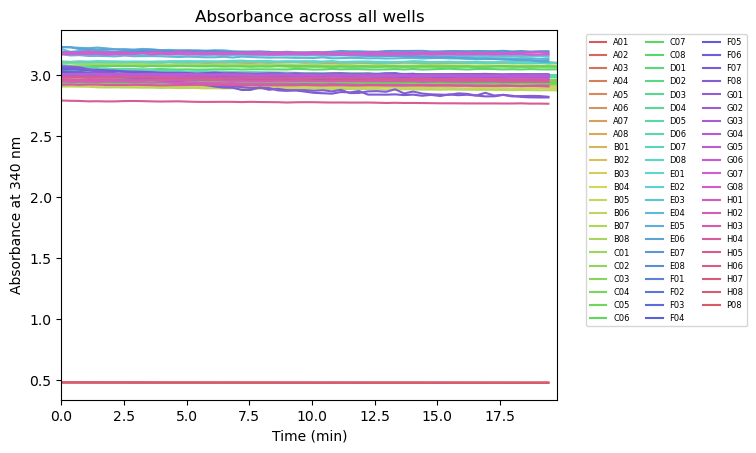

Selected Plate Type: 96-well
Selected blank wells: ['A03', 'B03', 'C03', 'D03', 'E03', 'F03', 'G03', 'H03']
Blank subtraction complete.
  well      OD  OD_blanked   time
0  A01  2.9250    -0.07663   0.00
1  A01  2.9197    -0.08193  21.60
2  A01  2.9193    -0.08233  43.19
3  A01  2.9200    -0.08163  64.79
4  A01  2.9197    -0.08193  86.39


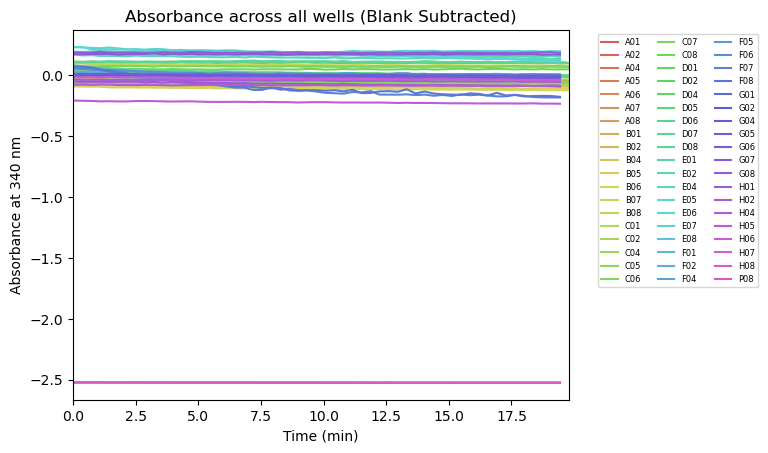

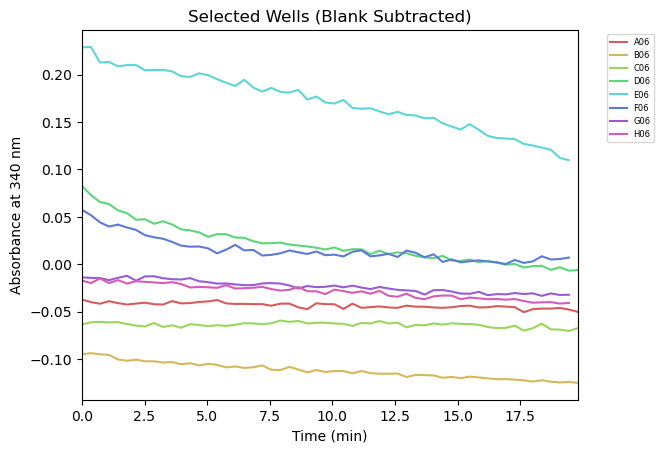

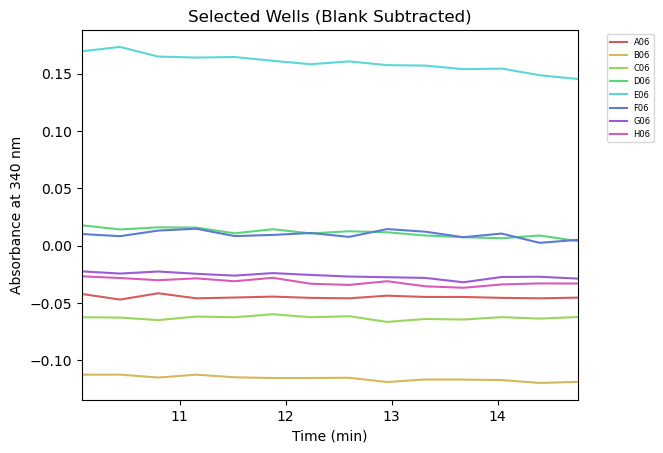

Stopping asyncio loop...


In [8]:
#BLOCK 8
# Main script execution
if __name__ == "__main__":
    root = Tk()

        
    root.withdraw()
    Abs_wavelength = None
    Fl_wavelength = None
    df = load_file()
    if Abs_wavelength is not None:
        plot_all_data(df, Abs_wavelength, "Absorbance")
    elif Fl_wavelength is not None:
        plot_all_data(df, Fl_wavelength, "Fluorescence")


    blank_selection = BlankSelectionApp(root, df)
    blank_selection.ask_for_plate_type()  
  #  blank_selection.ask_for_blank_subtraction()
    root.mainloop()